In [1]:
import pandas as pd
import numpy as np
from scipy.stats import beta as beta_dist
from scipy.special import hyp2f1
from scipy.special import beta as beta_func
from scipy.integrate import dblquad
import utils
import re
from functools import partial

In [23]:
input = utils.load_data([
    "../results/synthetic/1000/set4_aggregated/"
], "_x80_*")

data = utils.merge_exact(input, "exact_data_based")
data = data[~data.identifiable]

#data_ps1_0 = data[data['index'] == 2] 
#data_ps1_1 = data[data['index'] == 1]
#data = data[data['index'] > 2]


In [24]:
cols = [ int(re.match("pns_([0-9]+)", c)[1]) for c in data.columns if re.match("pns_[0-9]+",c) ]
cols.sort()
pns_l = data[[f"pns_{c}" for c in cols]].min(axis=1)

In [25]:
def fit(row, n, eps=0.0001) :
    samples = row[[f"pns_{c}" for c in range(n)]].values.astype(float)
    
    pos = row['pns_l_x'] - eps
    scale = row['pns_u_x'] - pos + 2 * eps
    params = beta_dist.fit(samples, floc = pos, fscale = scale)
        
    return params[0:2]


integral of scipy calls the fuction passing the inner variable first. 
 
Return the double (definite) integral of ``func(y, x)`` from ``x = a..b``
and ``y = gfun(x)..hfun(x)``.

In [26]:
def _p_beta2(x, y, L, alpha, beta, n):
    return (
        (L + x) ** alpha *  hyp2f1(alpha, 1 - beta, alpha + 1, (L + x) / (L + x + y)) -
         x ** alpha * hyp2f1(alpha, 1 - beta, alpha + 1, x / (L + x + y))
    ) / (
        alpha * (L + x + y) ** alpha * beta_func(alpha, beta) 
    ) ** n
    



def p_beta(row, n, delta=0.1, steps = 1000):
    alpha, beta = fit(row, n)
    b = row['pns_u_x'] 
    a = row['pns_l_x']
    L = b - a

    f = partial(_p_beta2, L = L, alpha = alpha, beta = beta, n = n)

    num, e1 = dblquad(f, 0, delta / 2, lambda x: 0, lambda x: delta / 2 )
    den, e2 = dblquad(f, 0,  a + (1 - b), lambda x: 0, lambda x: a + (1 - b) - x)
    
    return num/den


def p_unif(row, n, delta=0.1):
    b = row['pns_u_x'] 
    a = row['pns_l_x']
    L = b - a
    eps = delta / (2*L)
    return (1 + (1 + 2*eps)**(2 - n) - 2 * (1+ eps) ** (2-n)) / (1 - L ** (n - 2) - (n - 2) * (1 - L) * L ** (n - 2))

In [6]:
def prob_unif_data(data, n, delta):
    a = data['pns_u_x'] 
    b = data['pns_l_x']
    L = b - a
    eps = delta / (2*L)
    return (1 + (1 + 2*eps)**(2 - n) - 2 * (1+ eps) ** (2-n)) / (1 - L ** (n - 2) - (n - 2) * (1 - L) * L ** (n - 2))

<AxesSubplot:>

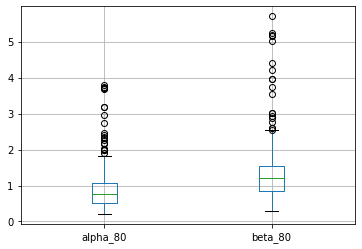

In [59]:
u = data.apply(partial(fit,n=80), axis=1)
pd.DataFrame(u.tolist(), index=u.index, columns=["alpha_80", "beta_80"]).boxplot()

In [38]:
n = 80
delta = 0.01
f = partial(p_beta, n=n, delta=delta)
data[f'p_beta_{n}_{delta}'] = data.apply(f, axis=1)
data[f'p_unif_{n}_{delta}'] = prob_unif_data(data, n, delta)

data.to_csv(f"temp_n{n}_{delta}.csv")

/var/folders/gc/vwr0wlvs149fjgmddd29dpw40000gn/T/ipykernel_92023/3259794314.py:2: RuntimeWarning: overflow encountered in double_scalars
  return (
/var/folders/gc/vwr0wlvs149fjgmddd29dpw40000gn/T/ipykernel_92023/3259794314.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (
/var/folders/gc/vwr0wlvs149fjgmddd29dpw40000gn/T/ipykernel_92023/3259794314.py:2: RuntimeWarning: overflow encountered in double_scalars
  return (
/Users/dhuber/anaconda3/envs/causal/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/dhuber/anaconda3/envs/causal/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being 

In [44]:
(data[[f"p_beta_{n}_0.001", f"p_beta_{n}_0.005", f"p_beta_{n}_0.01"]] > 1).sum()

p_beta_80_0.001     0
p_beta_80_0.005    12
p_beta_80_0.01     19
dtype: int64

In [16]:
data[['p_unif_20_0.005', 'pns_l_x', 'pns_u_x', 'pns_l_y', 'pns_u_y']]

,p_unif_20_0.005,pns_l_x,pns_u_x,pns_l_y,pns_u_y
3,0.096530,0.000362,0.173164,0.000000,0.007953
4,0.092248,0.000512,0.176749,0.000000,0.007953
5,119.466659,0.000095,0.020965,0.000000,0.007953
6,98.825417,0.000943,0.022477,0.000000,0.007953
7,34840.552461,0.000934,0.012276,0.000000,0.007953
...,...,...,...,...,...
1040,0.006960,0.001606,0.580924,0.079483,0.210324
1041,0.021226,0.011663,0.353491,0.079483,0.210324
1042,0.161122,0.079536,0.218463,0.079483,0.210324
1043,0.138038,0.063030,0.211296,0.079483,0.210324


In [288]:
pb abs= [ data.apply(p_beta, args=(n,), axis=1) for n in {20,40,60,80 }]

KeyboardInterrupt: 

Merge stuff